In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

In [2]:

# example text for model training (SMS messages)
simple_train = ['call you tonight', 'Call me a cab', 'please call me... PLEASE!']

In [3]:
simple_train

['call you tonight', 'Call me a cab', 'please call me... PLEASE!']

In [4]:
# example response vector
is_desperate = [0, 0, 1]


From the scikit-learn documentation:

>Text Analysis is a major application field for machine learning algorithms. However the raw data, a sequence of symbols cannot be fed directly to the algorithms themselves as most of them expect numerical feature vectors with a fixed size rather than the **raw text documents with variable length.**

We will use CountVectorizer to "convert text into a matrix of token counts":

In [5]:
# import and instantiate CountVectorizer (with the default parameters)
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

In [6]:
# learn the 'vocabulary' of the training data (occurs in-place)
vect.fit(simple_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

### Result
> Document  term matrix

- lower case
- singlular
- puntuation
- no duplication
- alpha order

In [7]:
# examine the fitted vocabulary
vect.get_feature_names()

['cab', 'call', 'me', 'please', 'tonight', 'you']

In [8]:
#vect.transform()

In [9]:
# transform training data into a 'document-term matrix'
simple_train_dtm = vect.transform(simple_train)
simple_train_dtm

<3x6 sparse matrix of type '<class 'numpy.int64'>'
	with 9 stored elements in Compressed Sparse Row format>

## Feature matrix
- 3x6



- 3 entries
- 6 features(toklens)

In [10]:
# convert sparse matrix to a dense matrix
simple_train_dtm.toarray()

array([[0, 1, 0, 0, 1, 1],
       [1, 1, 1, 0, 0, 0],
       [0, 1, 1, 2, 0, 0]])

In [11]:
# examine the vocabulary and document-term matrix together
pd.DataFrame(simple_train_dtm.toarray(), columns=vect.get_feature_names())

,cab,call,me,please,tonight,you
0,0,1,0,0,1,1
1,1,1,1,0,0,0
2,0,1,1,2,0,0


## Result

- 'call you tonight' --> `[0, 1, 0, 0, 1, 1]`
- 'Call me a cab' -> `[1, 1, 1, 0, 0, 0]`
- 'please call me... PLEASE!' -> `[0, 1, 1, 2, 0, 0]`

## Bag of word strategy

From the scikit-learn documentation:

In this scheme, features and samples are defined as follows:

- Each individual token occurrence frequency (normalized or not) is treated as a feature(**columns)**.
- The vector of all the token frequencies for a given document is considered a multivariate sample.

A **corpus of documents** can thus be represented by a matrix with one row per document and one column per token (e.g. word) occurring in the corpus.

We call **vectorization** the general process of turning a collection of text documents into numerical feature vectors. This specific strategy (tokenization, counting and normalization) is called the **Bag of Words** or "Bag of n-grams" representation. Documents are described by word occurrences while completely ignoring the relative position information of the words in the document.

### check the type of the document-term matrix


In [12]:
type(simple_train_dtm)

scipy.sparse.csr.csr_matrix

### examine the sparse matrix contents

- left: position on table
- right: value


In [13]:
print(simple_train_dtm)

  (0, 1)	1
  (0, 4)	1
  (0, 5)	1
  (1, 0)	1
  (1, 1)	1
  (1, 2)	1
  (2, 1)	1
  (2, 2)	1
  (2, 3)	2


## Understanding

- wide doc matrix
- has many zeros across
- 
### Sparse representation
- dont store zeros
- only store location & contents of the non zeros


From the [scikit-learn documentation](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction):

> As most documents will typically use a very small subset of the words used in the corpus, the resulting matrix will have **many feature values that are zeros** (typically more than 99% of them).

> For instance, a collection of 10,000 short text documents (such as emails) will use a vocabulary with a size in the order of 100,000 unique words in total while each document will use 100 to 1000 unique words individually.

> In order to be able to **store such a matrix in memory** but also to **speed up operations**, implementations will typically use a **sparse representation** such as the implementations available in the `scipy.sparse` package.

## # build a model to predict desperation


In [14]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(simple_train_dtm, is_desperate)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [15]:
# example text for model testing
simple_test = ["please don't call me"]

In order to **make a prediction**, the new observation must have the **same features as the training observations**, both in number and meaning.

skipt the fit, we only do transfrom

In [16]:
# transform testing data into a document-term matrix (using existing vocabulary)
simple_test_dtm = vect.transform(simple_test)
simple_test_dtm.toarray()

array([[0, 1, 1, 1, 0, 0]])

In [17]:
# examine the vocabulary and document-term matrix together
pd.DataFrame(simple_test_dtm.toarray(), columns=vect.get_feature_names())

,cab,call,me,please,tonight,you
0,0,1,1,1,0,0


### dont is missing
- is it ok?
- the model does not know the reationship between dont and desparation

### predict whether simple_test is desperate


In [18]:
knn.predict(simple_test_dtm)

array([1])

**Summary:**

- `vect.fit(train)` **learns the vocabulary** of the training data
- `vect.transform(train)` uses the **fitted vocabulary** to build a document-term matrix from the training data
- `vect.transform(test)` uses the **fitted vocabulary** to build a document-term matrix from the testing data (and **ignores tokens** it hasn't seen before)

## Read text to pandas

In [19]:
# read file into pandas from the working directory
sms = pd.read_table('yelp_data/sms.tsv', header=None, names=['label', 'message'])

In [20]:
sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [21]:
# examine the class distribution
sms.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [22]:
# convert label to a numerical variable
sms['label_num'] = sms.label.map({'ham':0, 'spam':1})

In [23]:
# check that the conversion worked
sms.head()

,label,message,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [24]:
# how to define X and y (from the SMS data) for use with COUNTVECTORIZER
X = sms.message
y = sms.label_num
print(X.shape)
print(y.shape)

(5572,)
(5572,)


In [25]:
# split X and y into training and testing sets
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4179,)
(1393,)
(4179,)
(1393,)


/home/salas/miniconda3/envs/nlp/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Vectorizing our dataset

In [26]:
# instantiate the vectorizer
vect = CountVectorizer()

In [27]:
# learn training data vocabulary, then use it to create a document-term matrix
vect.fit(X_train)
X_train_dtm = vect.transform(X_train)

In [28]:
# equivalently: combine fit and transform into a single step
X_train_dtm = vect.fit_transform(X_train)

In [29]:
# examine the document-term matrix
X_train_dtm

<4179x7456 sparse matrix of type '<class 'numpy.int64'>'
	with 55209 stored elements in Compressed Sparse Row format>

In [30]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
X_test_dtm

<1393x7456 sparse matrix of type '<class 'numpy.int64'>'
	with 17604 stored elements in Compressed Sparse Row format>

## Building and evaluating a model

We will use [multinomial Naive Bayes](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html):

> The multinomial Naive Bayes classifier is suitable for classification with **discrete features** (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

In [31]:
# import and instantiate a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [32]:
# train the model using X_train_dtm (timing it with an IPython "magic command")
%time nb.fit(X_train_dtm, y_train)

CPU times: user 0 ns, sys: 31.2 ms, total: 31.2 ms
Wall time: 11.8 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [33]:
# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

In [34]:
# # The magic happens here
# import matplotlib.pyplot as plt
# import scikitplot as skplt
# skplt.metrics.plot_roc(y_test, y_pred_class)
# plt.show()

In [35]:
len(y_pred_class)

1393

In [36]:
len(y_test)

1393

In [37]:
# calculate accuracy of class predictions
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.9885139985642498

In [38]:
# print the confusion matrix
metrics.confusion_matrix(y_test, y_pred_class)

array([[1203,    5],
       [  11,  174]])

In [39]:
# print message text for the false positives (ham incorrectly classified as spam)
X_test[y_test < y_pred_class]

574               Waiting for your call.
3375             Also andros ice etc etc
45      No calls..messages..missed calls
3415             No pic. Please re-send.
1988    No calls..messages..missed calls
Name: message, dtype: object

In [40]:
# print message text for the false negatives (spam incorrectly classified as ham)
X_test[y_test > y_pred_class]

3132    LookAtMe!: Thanks for your purchase of a video...
5       FreeMsg Hey there darling it's been 3 week's n...
3530    Xmas & New Years Eve tickets are now on sale f...
684     Hi I'm sue. I am 20 years old and work as a la...
1875    Would you like to see my XXX pics they are so ...
1893    CALL 09090900040 & LISTEN TO EXTREME DIRTY LIV...
4298    thesmszone.com lets you send free anonymous an...
4949    Hi this is Amy, we will be sending you a free ...
2821    INTERFLORA - It's not too late to order Inter...
2247    Hi ya babe x u 4goten bout me?' scammers getti...
4514    Money i have won wining number 946 wot do i do...
Name: message, dtype: object

In [41]:
# example false negative
X_test[3132]

"LookAtMe!: Thanks for your purchase of a video clip from LookAtMe!, you've been charged 35p. Think you can do better? Why not send a video in a MMSto 32323."

In [42]:
# calculate predicted probabilities for X_test_dtm (poorly calibrated)
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([2.87744864e-03, 1.83488846e-05, 2.07301295e-03, ...,
       1.09026171e-06, 1.00000000e+00, 3.98279868e-09])

In [43]:
# calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)

0.9866431000536962

## Comparing models

We will compare multinomial Naive Bayes with [logistic regression](http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression):

> Logistic regression, despite its name, is a **linear model for classification** rather than regression. Logistic regression is also known in the literature as logit regression, maximum-entropy classification (MaxEnt) or the log-linear classifier. In this model, the probabilities describing the possible outcomes of a single trial are modeled using a logistic function.

In [44]:
# import and instantiate a logistic regression model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [45]:
# train the model using X_train_dtm
%time logreg.fit(X_train_dtm, y_train)

CPU times: user 188 ms, sys: 0 ns, total: 188 ms
Wall time: 49.1 ms


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [46]:
# make class predictions for X_test_dtm
y_pred_class = logreg.predict(X_test_dtm)

In [47]:
# calculate predicted probabilities for X_test_dtm (well calibrated)
y_pred_prob = logreg.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([0.01269556, 0.00347183, 0.00616517, ..., 0.03354907, 0.99725053,
       0.00157706])

In [48]:
# calculate accuracy
metrics.accuracy_score(y_test, y_pred_class)

0.9877961234745154

In [60]:
# calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)

0.9936817612314301

In [55]:
#! pip install scikit-plot

In [51]:
import scikitplot as skplt
import matplotlib.pyplot as plt

In [52]:
# # The usual train-test split mumbo-jumbo
# from sklearn.datasets import load_digits
# from sklearn.model_selection import train_test_split
# from sklearn.naive_bayes import GaussianNB

# X, y = load_digits(return_X_y=True)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
# nb = GaussianNB()
# nb.fit(X_train, y_train)
# predicted_probas = nb.predict_proba(X_test)

# # The magic happens here
# import matplotlib.pyplot as plt
# import scikitplot as skplt
# skplt.metrics.plot_roc(y_test, predicted_probas)
# plt.show()

In [53]:
len(y_test)

1393

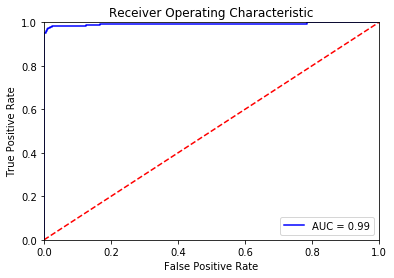

In [59]:
# calculate the fpr and tpr for all thresholds of the classification
probs = logreg.predict_proba(X_test_dtm)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

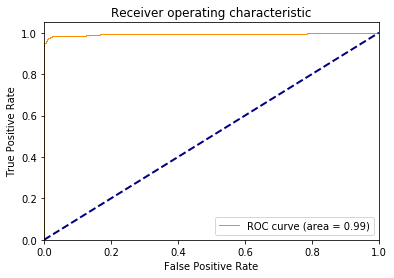

In [63]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()